<a href="https://colab.research.google.com/github/Joao-2003/python-projects/blob/main/Prova1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance pandas numpy matplotlib seaborn scipy

<ipython-input-11-3e41203da460>:21: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['Date'] = pd.to_datetime(data['Date']).dt.to_period('M').dt.to_timestamp()
<ipython-input-11-3e41203da460>:21: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['Date'] = pd.to_datetime(data['Date']).dt.to_period('M').dt.to_timestamp()



Estatísticas Descritivas:
          Média   Mediana       Moda  Desvio Padrão        Q1        Q2  \
PETR4  2.507753  1.119173 -44.790853      13.374014 -4.977077  1.119173   
VALE3  1.924380  0.721663 -27.780602      10.882360 -5.590330  0.721663   

             Q3        IQR     Mínimo     Máximo  
PETR4  8.746508  13.723585 -44.790853  61.673152  
VALE3  7.249570  12.839900 -27.780602  29.967008  

Outliers PETR4: 6 meses

Outliers VALE3: 7 meses

Teste t:
Estatística t = 0.369
Valor-p = 0.712


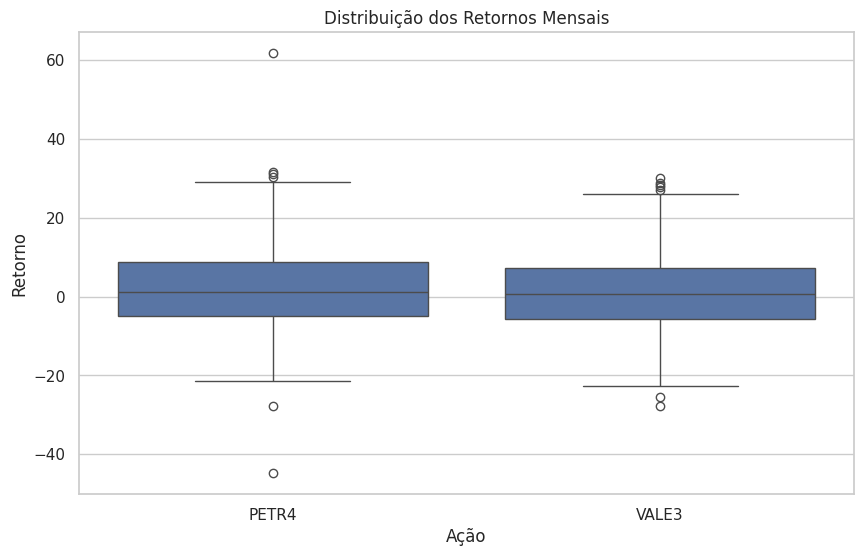

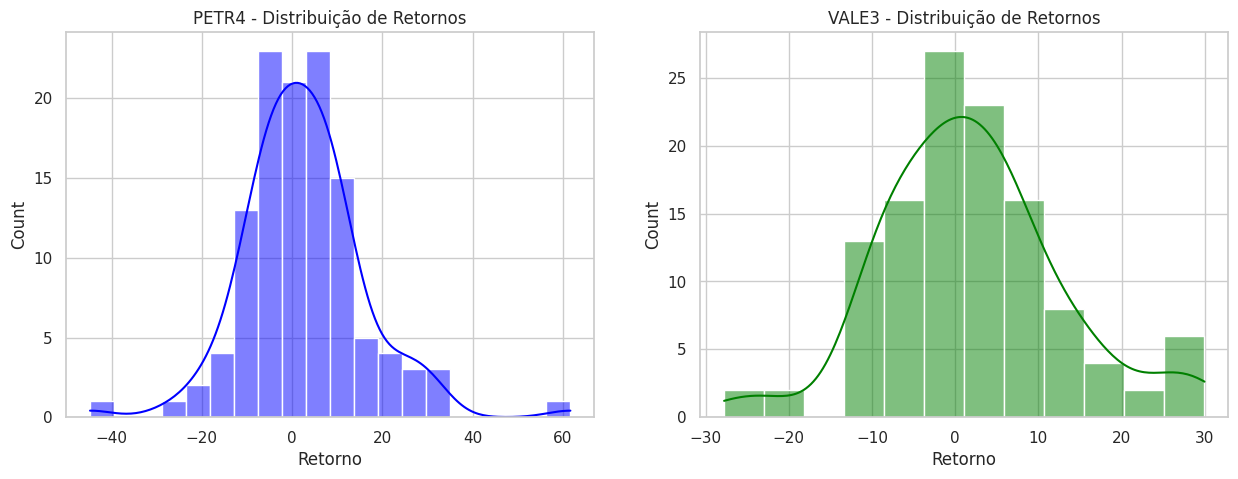

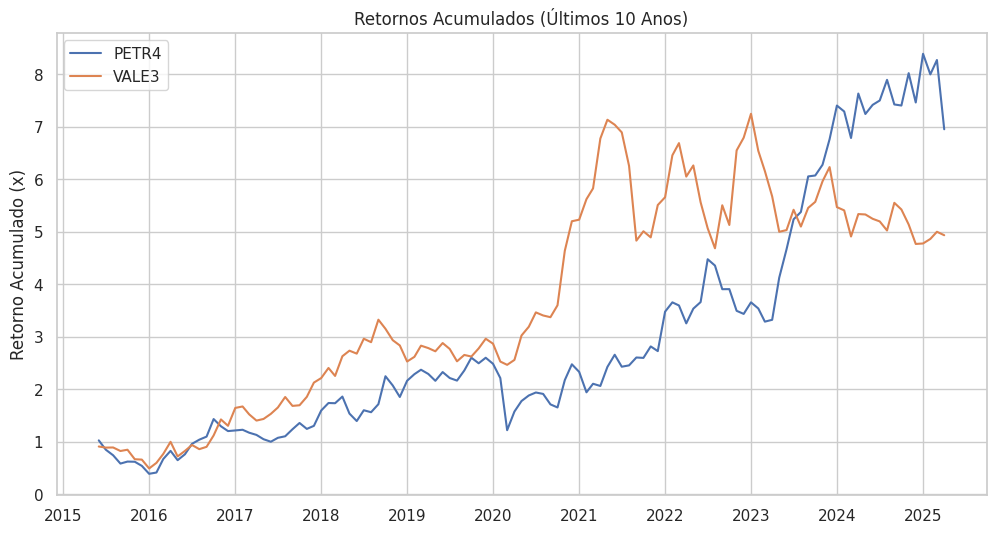


Conclusão:
1. PETR4 teve maior média de retorno (2.51% vs 1.92%)
2. VALE3 apresentou menor variabilidade (DP: 10.88% vs 13.37%)
3. Conservador: VALE3 | Arrojado: PETR4
4. Diferença significativa: Não (p = 0.712)



<Figure size 1200x600 with 0 Axes>

In [11]:
# -*- coding: utf-8 -*-
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Configurações iniciais
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# ========================
# 1. Coleta de Dados
# ========================

def download_data(ticker):
    data = yf.Ticker(ticker).history(period='10y', interval='1mo')
    data = data[['Close']].reset_index()
    data['Date'] = pd.to_datetime(data['Date']).dt.to_period('M').dt.to_timestamp()
    return data

# Baixar dados
petr4 = download_data('PETR4.SA')
vale3 = download_data('VALE3.SA')

# Salvar em CSV
petr4.to_csv('PETR4_10_anos.csv', sep=';', index=False)
vale3.to_csv('VALE3_10_anos.csv', sep=';', index=False)

# ========================
# 2. Cálculo de Retornos
# ========================

def calculate_returns(df, ticker):
    df['Retorno'] = df['Close'].pct_change() * 100
    df['Ação'] = ticker
    return df.dropna()

retornos_petr4 = calculate_returns(petr4.copy(), 'PETR4')
retornos_vale3 = calculate_returns(vale3.copy(), 'VALE3')

# Combinar e salvar
retornos_combinados = pd.concat([retornos_petr4, retornos_vale3])
retornos_combinados.to_csv('retornos_mensais.csv', sep=';', index=False)

# ========================
# 3. Estatística Descritiva
# ========================

def descriptive_stats(df, name):
    stats = {
        'Média': df['Retorno'].mean(),
        'Mediana': df['Retorno'].median(),
        'Moda': df['Retorno'].mode().iloc[0],
        'Desvio Padrão': df['Retorno'].std(),
        'Q1': df['Retorno'].quantile(0.25),
        'Q2': df['Retorno'].quantile(0.5),
        'Q3': df['Retorno'].quantile(0.75),
        'IQR': df['Retorno'].quantile(0.75) - df['Retorno'].quantile(0.25),
        'Mínimo': df['Retorno'].min(),
        'Máximo': df['Retorno'].max()
    }
    return pd.DataFrame(stats, index=[name])

stats_petr4 = descriptive_stats(retornos_petr4, 'PETR4')
stats_vale3 = descriptive_stats(retornos_vale3, 'VALE3')

# Exibir estatísticas
print("\nEstatísticas Descritivas:")
print(pd.concat([stats_petr4, stats_vale3]))

# ========================
# 4. Detecção de Outliers
# ========================

def find_outliers(df, name):
    q1 = df['Retorno'].quantile(0.25)
    q3 = df['Retorno'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    outliers = df[(df['Retorno'] < lower) | (df['Retorno'] > upper)]
    print(f"\nOutliers {name}: {len(outliers)} meses")
    return outliers

outliers_petr4 = find_outliers(retornos_petr4, 'PETR4')
outliers_vale3 = find_outliers(retornos_vale3, 'VALE3')

# ========================
# 5. Teste de Hipótese
# ========================

t_stat, p_value = stats.ttest_ind(retornos_petr4['Retorno'],
                                 retornos_vale3['Retorno'],
                                 equal_var=False)

print(f"\nTeste t:\nEstatística t = {t_stat:.3f}\nValor-p = {p_value:.3f}")

# ========================
# 6. Visualização
# ========================

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Ação', y='Retorno', data=retornos_combinados)
plt.title('Distribuição dos Retornos Mensais')
plt.show()
print("\n")

# Histogramas
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(retornos_petr4['Retorno'], kde=True, ax=ax[0], color='blue')
ax[0].set_title('PETR4 - Distribuição de Retornos')
sns.histplot(retornos_vale3['Retorno'], kde=True, ax=ax[1], color='green')
ax[1].set_title('VALE3 - Distribuição de Retornos')
plt.show()
print("\n")

# Retornos Acumulados
plt.figure(figsize=(12, 6))
plt.plot(retornos_petr4['Date'], (1 + retornos_petr4['Retorno']/100).cumprod(), label='PETR4')
plt.plot(retornos_vale3['Date'], (1 + retornos_vale3['Retorno']/100).cumprod(), label='VALE3')
plt.title('Retornos Acumulados (Últimos 10 Anos)')
plt.legend()
plt.ylabel('Retorno Acumulado (x)')
plt.show()

# ========================
# 7. Conclusão Analítica
# ========================

print('''
Conclusão:
1. PETR4 teve maior média de retorno ({}% vs {}%)
2. VALE3 apresentou menor variabilidade (DP: {}% vs {}%)
3. Conservador: VALE3 | Arrojado: PETR4
4. Diferença significativa: {} (p = {:.3f})
'''.format(
    round(stats_petr4['Média'].values[0], 2),
    round(stats_vale3['Média'].values[0], 2),
    round(stats_vale3['Desvio Padrão'].values[0], 2),
    round(stats_petr4['Desvio Padrão'].values[0], 2),
    'Sim' if p_value < 0.05 else 'Não',
    p_value
))

# Criar pasta de resultados
os.makedirs('resultados', exist_ok=True)
plt.savefig('resultados/analise_completa.png')